## EDA

In [69]:
import os
import wandb
import warnings
from hparams import *
import numpy as np
import pandas as pd 
import seaborn as sns
from models import  *
from utils import train_model,set_seeds
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
set_seeds(42)
warnings.filterwarnings('ignore')
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="1" # 1 for run in gpu -1 for run in cpu
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_GPU_ALLOCATOR'] ='cuda_malloc_async' 
%reload_ext autoreload
%autoreload 2


In [70]:

# root_dir=os.getcwd()
# root_dir

In [71]:
#loading dataframes
train_df = pd.read_csv('../data/Bone Age Training Set/train.csv')
df_test = pd.read_excel('../data/Bone Age Test Set/test.xlsx')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
df_test['Case ID'] = df_test['Case ID'].apply(lambda x: str(x)+'.png') 
df_test.rename(columns={'Ground truth bone age (months)': 'boneage'}, inplace=True)

train_df['img_path'] = train_df['id'].apply(lambda x: '../data/Bone Age Training Set/boneage-training-dataset/'+str(x))
df_test['img_path'] = df_test['Case ID'].apply(lambda x: '../data/Bone Age Test Set/boneage-testing-dataset/'+str(x)) 

train_df = train_df.head(200)

male      102
female     98
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='count'>

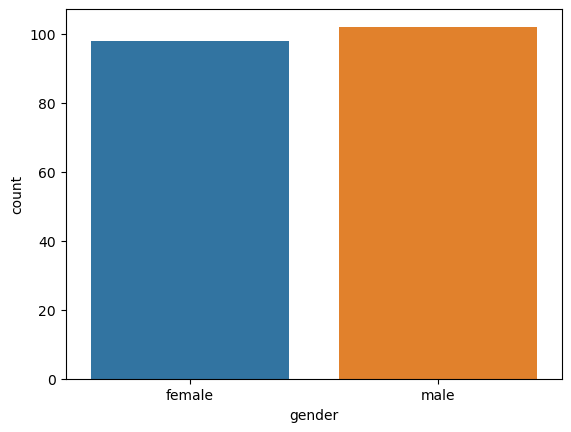

In [72]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [73]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 216 months
MIN age: 4 months
mean: 103.735
median: 106.0
         id  boneage   male  \
0  1377.png      180  False   
1  1378.png       12  False   
2  1379.png       94  False   
3  1380.png      120   True   
4  1381.png       82  False   

                                            img_path  gender  bone_age_z  
0  ../data/Bone Age Training Set/boneage-training...  female    1.523746  
1  ../data/Bone Age Training Set/boneage-training...  female   -1.832831  
2  ../data/Bone Age Training Set/boneage-training...  female   -0.194502  
3  ../data/Bone Age Training Set/boneage-training...    male    0.324969  
4  ../data/Bone Age Training Set/boneage-training...  female   -0.434257  


Text(0.5, 1.0, 'Number of children in each age group')

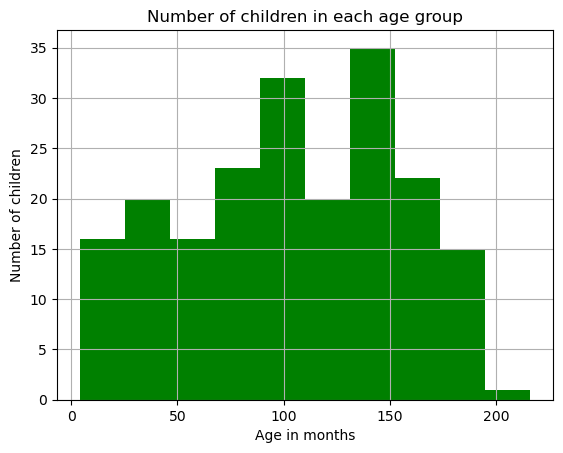

In [74]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

## Preprocess

In [75]:
#splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

In [76]:

train_data_generator = ImageDataGenerator(rescale=1.0/255.0)
val_data_generator = ImageDataGenerator(rescale=1.0/255.0)
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = '../data/Bone Age Training Set/boneage-training-dataset/',
    x_col= 'id',
    y_col= hparams.TARGET_VAR,
    batch_size = hparams.BATCH_SIZE,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (hparams.IMG_SIZE, hparams.IMG_SIZE))

#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '../data/Bone Age Training Set/boneage-training-dataset/',
    x_col = 'id',
    y_col = hparams.TARGET_VAR,
    batch_size = hparams.BATCH_SIZE,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (hparams.IMG_SIZE, hparams.IMG_SIZE))

#test data generator


# test_generator = test_data_generator.flow_from_directory(
#     directory = '../data/Bone Age Test Set/boneage-testing-dataset/',
#     shuffle = True,
#     class_mode = 'other',
#     color_mode = 'rgb',
#     target_size = (hparams.IMG_SIZE,hparams.IMG_SIZE))

test_generator = test_data_generator.flow_from_dataframe(
    dataframe = df_test,
    directory = '../data/Bone Age Test Set/boneage-testing-dataset/',
    x_col = 'Case ID',
    y_col = hparams.TARGET_VAR,
    batch_size = hparams.BATCH_SIZE,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (hparams.IMG_SIZE, hparams.IMG_SIZE))
test_x, test_y = next(test_generator)


train_steps = int(np.ceil(len(df_train) / hparams.BATCH_SIZE))
val_steps = int(np.ceil(len(df_valid) / hparams.BATCH_SIZE))

Found 160 validated image filenames.
Found 40 validated image filenames.
Found 200 validated image filenames.


In [77]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    """function to return mae in months"""
    return mean_absolute_error(
        (std_bone_age * x_p + mean_bone_age), (std_bone_age * y_p + mean_bone_age)
    )

model 1 = baseline, 2 = baseline_attention, 3 = unet, 
      4 = residual_attention_unet, 5= inception_attention_unet,
      6 = cnn_attention_unet

submodel for only model 2

submodel 1= one_attention_output_attention, 2= one_attention_output_cnn
         3= all_attention_output_attention, 4 = all_attention_output_cnn

In [78]:
if hparams.NORMALIZE_OUTPUT == True:
    metric = ['mae_in_months']
else:
    metric = ['mse']

if hparams.MODEL_NO == 1:
    hparams.MODEL_NAME = "baseline"
    model = BaselineCnn.baseline_cnn()
    
elif hparams.MODEL_NO == 2:
    hparams.MODEL_NAME = "baseline_attention_"+str(hparams.SUB_MODEL_NO)
    model =  BaselineCnnAttention.baseline_cnn_attention(hparams.SUB_MODEL_NO)

elif hparams.MODEL_NO == 3:
    model = Unet.unet()
    hparams.MODEL_NAME = "unet"

elif hparams.MODEL_NO == 4:
    model = ResidualAttentionUnet.residual_attention_unet()
    hparams.MODEL_NAME = "residual_attention_unet" 
elif hparams.MODEL_NO == 5:
    model = InceptionAttentionUnet.inception_attention_unet()
    hparams.MODEL_NAME = "inception_attention_unet" 
elif hparams.MODEL_NO == 6:
    model = CnnAttentionUnet.cnn_attention_unet()
    hparams.MODEL_NAME = "cnn_attention_unet" 

model.compile(loss ='mse', optimizer= 'adam',metrics = metric)
#model.compile(loss ='mse', optimizer= 'adam')
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_294 (Conv2D)            (None, 256, 256, 16  448         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     multiple             0           ['conv2d_294[0][0]',             
                                                                  'conv2d_295[0][0]',       

In [79]:

history = train_model(model, train_generator, val_generator, train_steps,val_steps)
wandb.config.update({"MODEL_NAME":hparams.MODEL_NAME})

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▃▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁
mse,█▃▃▂▂▂▃▂▁▁
test_mse,▁
val_loss,█▇▃▄▂▄▃▂▁▂
val_mse,█▇▃▄▂▄▃▂▁▂
best_epoch,8
best_val_loss,2161.104
epoch,9
loss,2488.47437


Epoch 1/10
20/20 [==============================] - 4s 211ms/step - loss: 7291.0391 - mse: 7291.0391 - val_loss: 4861.9795 - val_mse: 4861.9795 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - 4s 202ms/step - loss: 5566.2275 - mse: 5566.2275 - val_loss: 3548.4277 - val_mse: 3548.4277 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - 4s 199ms/step - loss: 3916.3618 - mse: 3916.3618 - val_loss: 3174.6248 - val_mse: 3174.6248 - lr: 0.0010
Epoch 4/10
20/20 [==============================] - 4s 193ms/step - loss: 2983.0220 - mse: 2983.0220 - val_loss: 6373.7163 - val_mse: 6373.7163 - lr: 0.0010
Epoch 5/10
20/20 [==============================] - 4s 194ms/step - loss: 3426.4700 - mse: 3426.4700 - val_loss: 3921.4673 - val_mse: 3921.4673 - lr: 0.0010
Epoch 6/10
20/20 [==============================] - 5s 244ms/step - loss: 2835.2671 - mse: 2835.2671 - val_loss: 2437.6174 - val_mse: 2437.6174 - lr: 0.0010
Epoch 7/10
20/20 [==============================] - 5s 227

In [80]:
art = wandb.Artifact(hparams.MODEL_NAME+"_best_model", type="model")
art.add_file("../data/artifact/" + hparams.MODEL_NAME + ".h5")
wandb.log_artifact(art)

## Evaluation

In [81]:
pred_y = model.predict(test_x)
#predicted = y_pred.flatten()
mse_value = mean_squared_error(test_y,pred_y)
wandb.log({"test_mse":mse_value})



1/1 [==============================] - 0s 77ms/step


## Garbage

In [ ]:
# x = train_df['img_path'].tolist()
# y = train_df['boneage'].tolist()
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
# train_dataset = create_dataset(x_train, y_train,
#                                batch_size=hparams.BATCH_SIZE,
#                                shuffle=True,
#                                cache_file=hparams.TRAIN_CACHE_PATH)

# val_dataset = create_dataset(x_val, y_val,
#                               batch_size=hparams.BATCH_SIZE,
#                               shuffle=False,
#                               cache_file=hparams.VAL_CACHE_PATH)

# train_steps = int(np.ceil(len(x_train) / hparams.BATCH_SIZE))
# val_steps = int(np.ceil(len(x_val) / hparams.BATCH_SIZE))

In [14]:
#wandb.save("../data/artifact/" + hparams.MODEL_NAME + ".h5")
# art = wandb.Artifact("best_model", type="model")
# art.add_file("../data/artifact/" + hparams.MODEL_NAME + ".h5")
# wandb.log_artifact(art)

In [ ]:

# model = AutoEncoder.auto_encoder()
# model.compile(loss ='mse', optimizer= 'adam',metrics = ['mse'])
# #model.compile(loss ='mse', optimizer= 'adam')
# model.summary()
# history = train_model(model, train_dataset, val_dataset,train_steps,val_steps)

## Checking GPU Status

import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

https://github.com/philipperemy/keras-attention-mechanism
https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831
https://github.com/bnsreenu/python_for_microscopists
https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py
https://github.com/robinvvinod/unet
https://www.datacamp.com/tutorial/autoencoder-classifier-python
https://www.kaggle.com/code/kmader/attention-on-pretrained-vgg16-for-bone-age




In [ ]:
# import tensorflow as tf
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu_devices[0], True)
# TF_FORCE_GPU_ALLOW_GROWTH=true

In [17]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# img = mpimg.imread('../data/Bone Age Training Set/boneage-training-dataset/1381.png')
# plt.imshow(img)
# print(img.shape)

In [ ]:
hparams.MODEL_NAME 